A notebook to explore catalogs based on SDSS/PanSTARRS data, given on WEAVE-Apertif internal page: https://ingconfluence.ing.iac.es:8444/confluence/pages/viewpage.action?spaceKey=WEAVEDEV&title=WEAVE-Apertif%3A+internal+team+page

In [1]:
%matplotlib inline

In [22]:
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt

In [3]:
hdul = fits.open('/Users/adams/data/weave/LRA_Confluence_COMPLETE_List.fits')
data = hdul[1].data

In [4]:
cols = hdul[1].columns
cols.info()

name:
    ['OBJECT', 'RA', 'DEC', 'MAG_G', 'MAG_R', 'Z', 'HI_MASS', 'STELLAR_MASS', 'RMAX', 'MAXMAG', 'FIT_FLAG', 'STAR_FLAG', 'HRV_RBIN', 'HRV_MAX_MAG', 'LRV_RBIN', 'LRV_MAX_MAG', 'HRA_RBIN', 'HRA_MAX_MAG', 'LRA_RBIN', 'LRA_MAX_MAG', 'EPS', 'INCLIN', 'SMA', 'SMB', 'CEN_SB', 'HRV_EXPTIME', 'HRV_LIM_SNR', 'HRV_NBINS', 'LRV_EXPTIME', 'LRV_LIM_SNR', 'LRV_NBINS', 'HRA_EXPTIME', 'HRA_LIM_SNR', 'HRA_NBINS', 'LRA_EXPTIME', 'LRA_LIM_SNR', 'LRA_NBINS', 'CATALOG']
format:
    ['19A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'D', 'I', 'D', 'D', 'I', 'D', 'D', 'I', 'D']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bscale:
  

In [5]:
print(len(data))

2117


Based on looking at pdfs of the targets, I saw that many were repeated multiple times.


I would like to quantify this. In order to do so, I will search for sources that are within 0.75' of another target (half LIFU field of view). I will iterate through the catalog, checking each source. I will record duplicates, and skip those when I continue my iterations. Then I can check length of duplicate list at the end, to find out how many sources (roughly) should be dropped).

In [30]:
#first, turn RA,Dec into sky coords so I can do easy calcs!
cat_coords = SkyCoord(data['RA'],data['DEC'],frame='icrs',unit='deg')
#print(cat_coords)

#print(len(cat_coords))

#create empty list to hold duplicates
duplicate_list = np.empty(0)
main_duplicate_list = np.empty(0) #separate array to hold first detection of duplicate
offset = np.empty(0)
magrdiff = np.empty(0)

c= cat_coords[10]
#print(c.separation(cat_coords))

#now iterate through data
#for i in range(len(data)):
for i in range(len(data)): #range(len(data)):
    #print(i)
    if not data['OBJECT'][i].strip() in duplicate_list:
    #    print('Already found as duplicate')
    #else:
        #find distance to all galaxies
        c = cat_coords[i]
        sep = c.separation(cat_coords).value
        ind = np.where(sep < 0.75/60.)[0]
        #print(ind,len(ind))
        #check if there is more than one entry:
        if len(ind) >1 :
            main_duplicate_list = np.append(main_duplicate_list,data['OBJECT'][i].strip())
            ind_dupl = ind[1:] #skip first index, which should be self (thanks to check)
            #print(i,ind_dupl)
            duplicate_list = np.append(duplicate_list,data['OBJECT'][ind_dupl].strip())
            #print(duplicate_list)
            #now fill some values to track how erroneous things are
            offset = np.append(offset,sep[ind_dupl])
            magrdiff = np.append(magrdiff,data['MAG_G'][ind_dupl]-data['MAG_G'][i])
            
print(len(duplicate_list),len(main_duplicate_list))
#print(duplicate_list)

/Users/adams/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


517 314
['1237658204514746368' '1237657612339249152' '1237658800968761344'
 '1237665443125067776' '1237655106766635008' '1237667324334440704'
 '155210569158776821' '155180481400373657' '155180481378823363'
 '155180481373112445' '155180481349081504' '155180481370501005'
 '155143324119121561' '155133324060979992' '155133324007249345'
 '155133439334768341' '155090555973044411' '155090556001503977'
 '155090556019892201' '155083334534695746' '155083334537034525'
 '155083334579353629' '155080330561193295' '154983382890597290'
 '154903371832526087' '154903371844825942' '154903371818023977'
 '154903371853142390' '154903371886640761' '154893371862159938'
 '154893371892299384' '154530321828680279' '154520182597753378'
 '154520182570182827' '154520182607432704' '154520182625471790'
 '154520182567731788' '154073325593550678' '154050470657483455'
 '153690345248160673' '153680345238998961' '153563356671549730'
 '153450487559709847' '153450487556828912' '153410429042353909'
 '153410429066123295' '153

In [41]:
print('There are {0} duplicates that should be removed'.format(len(duplicate_list)))
print('There are {0} galaxies remaining in sample that had duplicates'.format(len(main_duplicate_list)))


There are 517 duplicates that should be removed
There are 314 galaxies remaining in sample that had duplicates


0.72


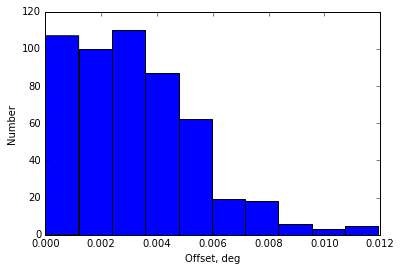

In [42]:
#make plots of distribution of spatial offset and mag difference
#highlight any large cases and go investigate them

plt.hist(offset)
plt.xlabel('Offset, deg')
plt.ylabel('Number')
print(0.012*60)

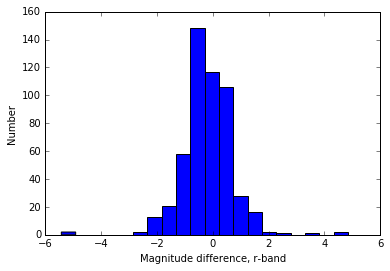

In [44]:
plt.hist(magrdiff,bins=20)
plt.xlabel('Magnitude difference, r-band')
plt.ylabel('Number')

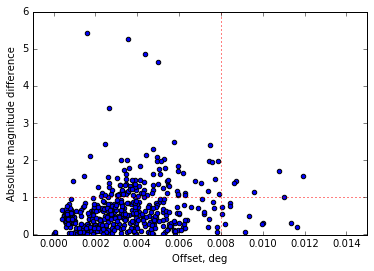

In [45]:
plt.scatter(offset,abs(magrdiff))
plt.axis([-0.001,0.015,-0.01,6])
plt.plot([-1,1],[1,1],'r:')
plt.plot([0.008,0.008],[0,6],'r:')
plt.xlabel('Offset, deg')
plt.ylabel('Absolute magnitude difference')

In [40]:
#0.008 deg = 30"
ind_30arcsec = np.where(offset <= 30./3600.)[0]
ind_1mag = np.where(abs(magrdiff) >= 1.)[0]

print('There are {0} duplicates with offsets less than 30"'.format(len(ind_30arcsec)))
print('There are {0} dupliates with magnitude differences greater than 1 mag!'.format(len(ind_1mag)))

There are 503 duplicates with offsets less than 30"
There are 109 dupliates with magnitude differences greater than 1 mag!
